# Investigating digit-by-digit learning

This notebook looks into the "steps" visible in the loss curve where the models seems to learn one digit at a time.

Here is the training curves for NanoGPT on 7x7 addition with answer zero padding:

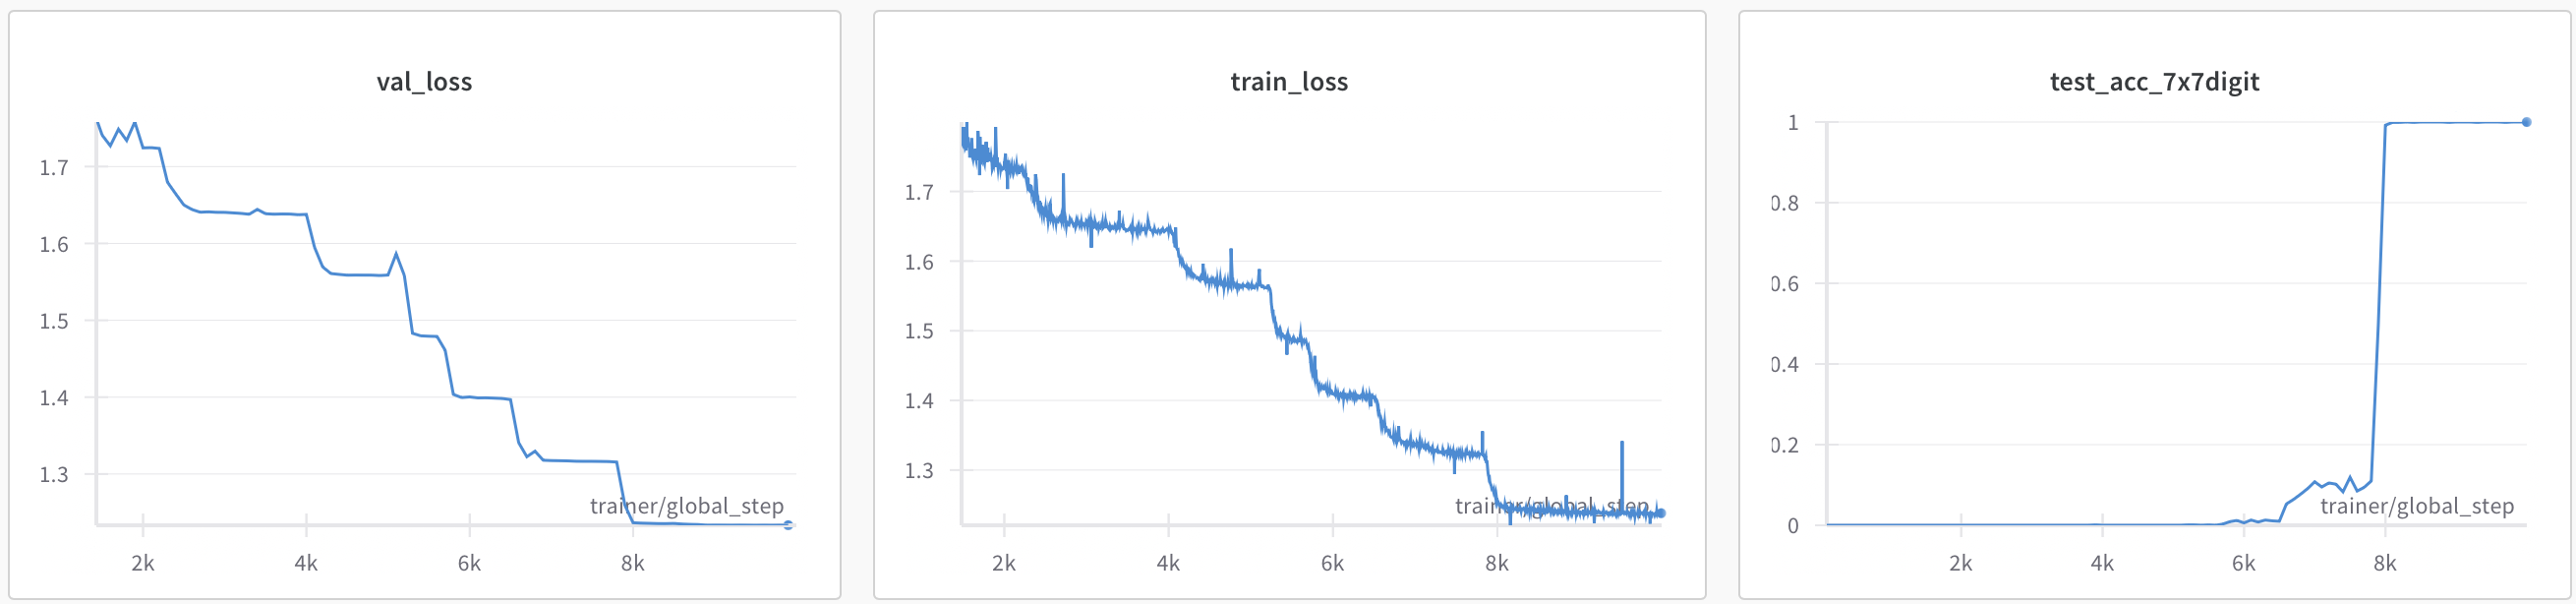

In [1]:
import json
from pathlib import Path

import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arithmetic_lm.constants import PLOTS_DIR


%matplotlib inline

In [2]:
WANDB_ENTITY = "compositional-generalization-ut"

## Get history from wandb

In [3]:
wandb_project = "addition-7x7-digit-pad-ans-zero"
wandb_run_id = "24jagq4h"


# init run
api = wandb.Api()
run = api.run(f"{WANDB_ENTITY}/{wandb_project}/{wandb_run_id}")

# get history
full_history = pd.DataFrame(run.scan_history())

In [4]:
history = full_history[
    ["trainer/global_step", "train_loss", "val_loss", "test_acc_7x7digit", "samples"]
]

# rename "trainer/global_step" to "step"
history = history.rename(columns={"trainer/global_step": "step"})

# set step as index
history = history.set_index("step")

history

,train_loss,val_loss,test_acc_7x7digit,samples
step,,,,
4,NaN,NaN,NaN,"{'nrows': 6, 'path': 'media/table/samples_0_d1..."
4,74.355957,NaN,NaN,None
9,NaN,NaN,NaN,None
9,21.176113,NaN,NaN,None
14,NaN,NaN,NaN,None
...,...,...,...,...
9994,1.238096,NaN,NaN,None
9999,NaN,NaN,NaN,None
9999,1.235794,NaN,NaN,None


## Get predictions over steps

In [5]:
# get tables for the run
tables = []
artifacts = run.logged_artifacts(per_page=10000)
for art in artifacts:
    if art.type == "run_table":
        table = art.download()
        tables.append(table)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downlo

In [6]:
# get steps where tables were logged from samples column
tables_steps = history["samples"].dropna().index
assert len(tables) == len(tables_steps), (
    f"Number of tables and tables_steps do not match ({len(tables)} and {len(tables_steps)}), tables_steps: "
    + str(tables_steps)
)
tables_steps

Index([   4,  104,  204,  304,  404,  504,  604,  704,  804,  904,
       ...
       9104, 9204, 9304, 9404, 9504, 9604, 9704, 9804, 9904, 9999],
      dtype='int64', name='step', length=101)

In [7]:
def process_table_json(path) -> pd.DataFrame:
    with open(Path(path) / "samples.table.json", "r") as f:
        table = json.load(f)
    df = pd.DataFrame(table["data"], columns=table["columns"])
    return df

In [8]:
predictions = {}
for ts, table in zip(tables_steps, tables):
    df = process_table_json(table)
    predictions[ts] = df

predictions = (
    pd.concat(predictions, names=["step"]).reset_index(level=0).reset_index(drop=True)
)
predictions

,step,dataset,prompt,answer,pred_answer,correct
0,4,test_7x7digit,'\n$2718005+1660515=','02587340$\n','==========',False
1,4,test_7x7digit,'\n$3111679+8743366=','54055811$\n','==========',False
2,4,test_7x7digit,'\n$6022535+6844124=','95666821$\n','==========',False
3,4,test_train_subset,'\n$7205747+5914501=','84202131$\n','==========',False
4,4,test_train_subset,'\n$6089386+7726580=','66951831$\n','==========',False
...,...,...,...,...,...,...
601,9999,test_7x7digit,'\n$9590634+8302340=','47929871$\n','47929871$\n',True
602,9999,test_7x7digit,'\n$6548229+6592431=','06604131$\n','06604131$\n',True
603,9999,test_train_subset,'\n$6590820+2180440=','06217780$\n','06217780$\n',True
604,9999,test_train_subset,'\n$9835677+6682985=','26681561$\n','26681561$\n',True


### How many digits in the predicted answer are correct

In [9]:
def how_many_correct(answer: str, pred_answer: str) -> int:
    """Count how many digits from the right are correct"""
    # keep only digits in the answer
    answer = "".join([c for c in answer if c.isdigit()])
    pred_answer = "".join([c for c in pred_answer if c.isdigit()])
    if not pred_answer:
        return 0
    for i, (a, p) in enumerate(zip(answer[::-1], pred_answer[::-1])):
        if a != p:
            return i
    return len(answer)


predictions["n_correct_digits"] = predictions.apply(
    lambda x: how_many_correct(x["answer"], x["pred_answer"]), axis=1
)
predictions

,step,dataset,prompt,answer,pred_answer,correct,n_correct_digits
0,4,test_7x7digit,'\n$2718005+1660515=','02587340$\n','==========',False,0
1,4,test_7x7digit,'\n$3111679+8743366=','54055811$\n','==========',False,0
2,4,test_7x7digit,'\n$6022535+6844124=','95666821$\n','==========',False,0
3,4,test_train_subset,'\n$7205747+5914501=','84202131$\n','==========',False,0
4,4,test_train_subset,'\n$6089386+7726580=','66951831$\n','==========',False,0
...,...,...,...,...,...,...,...
601,9999,test_7x7digit,'\n$9590634+8302340=','47929871$\n','47929871$\n',True,8
602,9999,test_7x7digit,'\n$6548229+6592431=','06604131$\n','06604131$\n',True,8
603,9999,test_train_subset,'\n$6590820+2180440=','06217780$\n','06217780$\n',True,8
604,9999,test_train_subset,'\n$9835677+6682985=','26681561$\n','26681561$\n',True,8


In [10]:
n_correct_digits = predictions.groupby("step")["n_correct_digits"].median()

## Plot

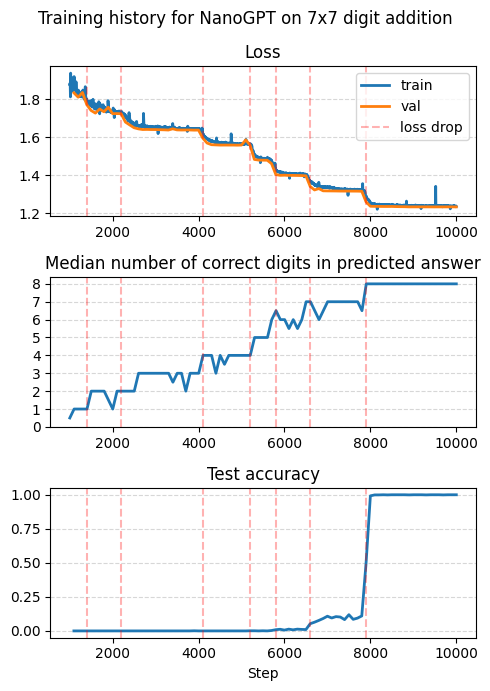

In [11]:
min_step = 1000
max_step = None

train_loss = history["train_loss"].dropna().loc[min_step:max_step]
val_loss = history["val_loss"].dropna().loc[min_step:max_step]
test_acc = history["test_acc_7x7digit"].dropna().loc[min_step:max_step]

fig, ax = plt.subplots(3, 1, figsize=(5, 7), sharex=True)

ax[0].plot(train_loss, linewidth=2, label="train")
ax[0].plot(val_loss, linewidth=2, label="val")
ax[0].grid(alpha=0.5, linestyle="--", axis="y")
ax[0].xaxis.set_tick_params(labelbottom=True)
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(n_correct_digits.loc[min_step:max_step], linewidth=2)
ax[1].set_yticks(np.arange(0, 9))
ax[1].grid(alpha=0.5, linestyle="--", axis="y")
ax[1].xaxis.set_tick_params(labelbottom=True)
ax[1].set_title("Median number of correct digits in predicted answer")

ax[2].plot(test_acc, linewidth=2)
ax[2].grid(alpha=0.5, linestyle="--", axis="y")
ax[2].xaxis.set_tick_params(labelbottom=True)
ax[2].set_title("Test accuracy")
ax[2].set_xlabel("Step")

# vertical lines for loss step drops
loss_drops = [1400, 2200, 4100, 5200, 5800, 6600, 7900]
for loss_drop in loss_drops:
    for axi in ax:
        axi.axvline(
            loss_drop, color="red", linestyle="--", alpha=0.3, label="loss drop"
        )

# to add loss drop labels
ax[0].legend()
# remove duplicates
handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys())

fig.suptitle("Training history for NanoGPT on 7x7 digit addition")
plt.tight_layout()
plt.savefig(
    PLOTS_DIR / "exp_6_7x7_addition_nanogpt_digit_learning.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()